In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_candidates = pd.read_csv('../data/wombi_candidates.csv')
df_employees = pd.read_csv('../data/wombi_employees.csv')

In [4]:
from sklearn.model_selection import train_test_split
X = df_employees.drop('score',axis=1)
y = df_employees['score']

In [5]:
X['most_recent_income']= X['most_recent_income'].replace(',','', regex=True).apply(pd.to_numeric)

In [6]:
# print(X.select_dtypes(include=['number']).columns)
X_num = X[['age', 'college_degree', 'problem_solving_skill', 'technology_skill',
       'english_skill','wombus_id','most_recent_income','total_jobs']]
# print(X.select_dtypes(include=['object']).columns)
X_ohe_cat = X[['birth_continent', 'gender', 'shirt_color_preference',
              'remote_work_preference','industry_preference']]
X_ord_cat = X[['customer_exp_preference', 'work_env_preference',
              'personal_growth_preference', 'honest_communication_preference',
              'community_service_preference']]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer

In [8]:
# Create the numerical pipeline
num_pipeline = make_column_transformer(
       (SimpleImputer(strategy="most_frequent"),['age','college_degree']),
       (SimpleImputer(strategy="mean"),['problem_solving_skill', 'technology_skill','english_skill']),
       (SimpleImputer(strategy="most_frequent"),['total_jobs']),
       (SimpleImputer(strategy="mean"),['most_recent_income']),remainder='drop')

# Create the categorical pipeline for both one-hot encoding and ordinal encoding
cat_ohe_pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy='most_frequent'))
                    ,('ohe',OneHotEncoder())])
cat_ord_pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy='most_frequent')),
                    ('ordinal',OrdinalEncoder())])
# Add standardscaler to the numeric pipeline
num_pipeline1 = Pipeline([('imp_num_pipeline',num_pipeline),
                        ('scaler',StandardScaler())])

In [9]:
# Use ColumnTransformer to combine pipelines and create a workflow for the ML process
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)
cat_ohe_attribs = list(X_ohe_cat)
cat_ord_attribs = list(X_ord_cat)

# print(num_attribs)
# print(cat_ohe_attribs)
# print(cat_ord_attribs)

full_pipeline = ColumnTransformer([
            ('num', num_pipeline1, num_attribs),
            ('cat_ohe', cat_ohe_pipeline,cat_ohe_attribs),
            ('cat_ord',cat_ord_pipeline,cat_ord_attribs)])

In [19]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imp_num_pipeline',
                                                  ColumnTransformer(transformers=[('simpleimputer-1',
                                                                                   SimpleImputer(strategy='most_frequent'),
                                                                                   ['age',
                                                                                    'college_degree']),
                                                                                  ('simpleimputer-2',
                                                                                   SimpleImputer(),
                                                                                   ['problem_solving_skill',
                                                                                    'technology_skill',
                                                                                    'english_skill']),
                                                                                  ('simpleimputer-3',
                                                                                   SimpleImputer(strategy='most_frequent'),
                                                                                   ['...
                                 ['birth_continent', 'gender',
                                  'shirt_color_preference',
                                  'remote_work_preference',
                                  'industry_preference']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['customer_exp_preference',
                                  'work_env_preference',
                                  'personal_growth_preference',
                                  'honest_communication_preference',
                                  'community_service_preference'])])

In [10]:
# fit transform your X
X_prepared = full_pipeline.fit_transform(X)

In [11]:
# Split the the dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_prepared,y,test_size=0.2, random_state=2)

In [12]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [23]:
hidden_layers_sizes = [129]
batch_size=[128]
param_grid = dict(hidden_layer_sizes=hidden_layers_sizes, batch_size=batch_size)
model = MLPRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', return_train_score=True, cv=5)
grid_result = grid.fit(X_train,y_train)

In [24]:
best_params = grid_result.best_params_

In [25]:
best_params

{'batch_size': 128, 'hidden_layer_sizes': 129}

In [30]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",np.sqrt(grid.best_score_*-1))
print("\n The best parameters across ALL searched params:\n",grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 MLPRegressor(batch_size=128, hidden_layer_sizes=129)

 The best score across ALL searched params:
 3.9159254849701086

 The best parameters across ALL searched params:
 {'batch_size': 128, 'hidden_layer_sizes': 129}


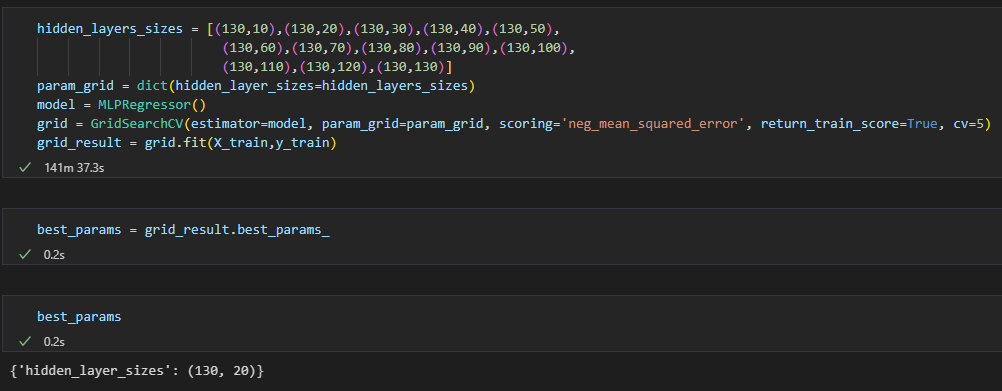

In [13]:
# hidden_layers_sizes = [(130,10),(130,20),(130,30),(130,40),(130,50),
#                         (130,60),(130,70),(130,80),(130,90),(130,100),
#                         (130,110),(130,120),(130,130)]
# param_grid = dict(hidden_layer_sizes=hidden_layers_sizes)
# model = MLPRegressor()
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', return_train_score=True, cv=5)
# grid_result = grid.fit(X_train,y_train)

In [14]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
# print("\n The best score across ALL searched params:\n",np.sqrt(grid.best_score_*-1))
# print("\n The best parameters across ALL searched params:\n",grid.best_params_)

In [15]:
ml_pipeline = Pipeline([
            ('transformer',full_pipeline),
            ('MLP',MLPRegressor(activation='relu',alpha=0.0001, batch_size=128,
            hidden_layer_sizes=129, learning_rate_init=0.001, solver='adam'))])

In [16]:
ml_pipeline.fit(X,y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_num_pipeline',
                                                                   ColumnTransformer(transformers=[('simpleimputer-1',
                                                                                                    SimpleImputer(strategy='most_frequent'),
                                                                                                    ['age',
                                                                                                     'college_degree']),
                                                                                                   ('simpleimputer-2',
                                                                                                    SimpleImputer(),
                                                                                                    ['problem_solving_skill',
                                                                                                     'technology_skill',
                                                                                                     'english_skill']),
                                                                                                   ('simpleimputer-3',
                                                                                                    SimpleImput...
                                                   'remote_work_preference',
                                                   'industry_preference']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['customer_exp_preference',
                                                   'work_env_preference',
                                                   'personal_growth_preference',
                                                   'honest_communication_preference',
                                                   'community_service_preference'])])),
                ('MLP', MLPRegressor(batch_size=128, hidden_layer_sizes=129))])

In [17]:
test_predictions = ml_pipeline.predict(X)

In [18]:
pred_df = pd.DataFrame(y.values, columns=['Test Y'])
test_predictions = pd.DataFrame(test_predictions)
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test Y','Model Predictions']
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.sqrt(mean_squared_error(pred_df['Test Y'], pred_df['Model Predictions']))

3.8133296055200705

In [19]:
pred_df

,Test Y,Model Predictions
0,61.06,62.071500
1,53.20,57.064312
2,70.18,63.421204
3,58.37,58.648674
4,61.77,61.351208
...,...,...
233931,59.15,60.282607
233932,44.12,46.642960
233933,65.28,67.820684
233934,61.65,61.930490


In [23]:
X_cand = df_candidates
X_cand['most_recent_income']=X_cand['most_recent_income'].replace(',','', regex=True).apply(pd.to_numeric)

In [24]:
cand_score = ml_pipeline.predict(X_cand)

In [26]:
cand_score[0]

61.593680219362845

In [27]:
# Add our predicted score to the dataframe, clean our data whether it's imputing or other fill method, and save the dataframe in a new csv file
df_candidates['score'] = cand_score.tolist()

# I'll just go ahead and add the similar method of fill, though more of a manual process. Tedious, but I've already used it and it worked the same

df_candidates['shirt_color_preference'] = df_candidates['shirt_color_preference'].replace(np.nan,'Purple')
df_candidates['work_env_preference'] = df_candidates['work_env_preference'].replace(np.nan, 'Strongly Agree')
df_candidates['personal_growth_preference'] = df_candidates['personal_growth_preference'].replace(np.nan, 'Agree')
df_candidates['honest_communication_preference'] = df_candidates['honest_communication_preference'].replace(np.nan, 'Neutral')
df_candidates['community_service_preference'] = df_candidates['community_service_preference'].replace(np.nan,'Strongly Agree')
df_candidates['industry_preference'] = df_candidates['industry_preference'].replace(np.nan,'Tech')
df_candidates['birth_continent'] = df_candidates['birth_continent'].replace(np.nan,'North America')
df_candidates['remote_work_preference'] = df_candidates['remote_work_preference'].replace(np.nan,"Hybrid")
df_candidates['gender'] = df_candidates['gender'].replace(np.nan,'Female')
df_candidates['customer_exp_preference'] = df_candidates['customer_exp_preference'].replace(np.nan,'Neutral')
df_candidates['college_degree'] = df_candidates['college_degree'].replace(np.nan,0).astype('int')
df_candidates['age'] = df_candidates['age'].replace(np.nan,int(df_employees['age'].mean())).astype('int')
df_candidates['problem_solving_skill'] = df_candidates['problem_solving_skill'].replace(np.nan,df_candidates['problem_solving_skill'].mean())
df_candidates['english_skill'] = df_candidates['english_skill'].replace(np.nan, df_candidates['english_skill'].mean())
df_candidates['technology_skill'] = df_candidates['technology_skill'].replace(np.nan, df_candidates['technology_skill'].mean())
df_candidates['most_recent_income'] = df_candidates['most_recent_income'].replace(',','', regex=True).apply(pd.to_numeric)
df_candidates['most_recent_income'] = df_candidates['most_recent_income'].replace(np.nan, int(df_candidates['most_recent_income'].median()))
df_candidates['total_jobs'] = df_candidates['total_jobs'].replace(np.nan, 4)

In [28]:
df_candidates

,wombus_id,birth_continent,gender,age,college_degree,problem_solving_skill,technology_skill,english_skill,most_recent_income,total_jobs,shirt_color_preference,customer_exp_preference,work_env_preference,personal_growth_preference,honest_communication_preference,community_service_preference,remote_work_preference,industry_preference,score
0,1105,North America,Female,44,0,8.400397,23.348271,9.105426,77367.0,5.0,Purple,Strongly Disagree,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Higher Education,61.593680
1,1106,North America,Female,52,1,7.787927,24.799825,9.095713,78979.0,4.0,Blue,Neutral,Strongly Disagree,Disagree,Strongly Agree,Strongly Agree,Hybrid,Finance,68.147737
2,1107,North America,Male,32,0,23.005739,25.484927,8.967305,38932.0,4.0,Blue,Strongly Disagree,Disagree,Agree,Agree,Neutral,On-Site,Finance,51.070293
3,1108,Africa,Male,49,0,15.565866,25.027173,5.914387,58511.0,4.0,Purple,Disagree,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Tech,58.449161
4,1109,North America,Male,47,0,12.784366,30.619283,8.751296,65831.0,4.0,Purple,Strongly Disagree,Disagree,Neutral,Strongly Agree,Strongly Agree,On-Site,Renewable Energy,65.491994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,1549,North America,Male,37,0,14.054447,24.158402,9.376241,62488.0,4.0,Purple,Neutral,Strongly Agree,Agree,Neutral,Disagree,Hybrid,Higher Education,50.344263
445,1550,North America,Male,67,1,12.323157,28.663559,9.351957,67044.0,4.0,Blue,Neutral,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Hybrid,Higher Education,70.503223
446,1551,North America,Male,40,0,19.641136,25.027173,9.137611,47786.0,3.0,Purple,Neutral,Strongly Agree,Agree,Agree,Agree,Hybrid,Renewable Energy,56.938158
447,1552,Asia,Female,58,0,19.343434,25.027173,6.046407,48570.0,2.0,Blue,Disagree,Strongly Disagree,Agree,Neutral,Strongly Agree,Hybrid,Finance,56.685539


In [29]:
df_candidates.to_csv('../data/test_score.csv', index=False)

In [30]:
df_wombus = pd.read_csv('../data/test_score.csv')
df_wombus.head(5)

,wombus_id,birth_continent,gender,age,college_degree,problem_solving_skill,technology_skill,english_skill,most_recent_income,total_jobs,shirt_color_preference,customer_exp_preference,work_env_preference,personal_growth_preference,honest_communication_preference,community_service_preference,remote_work_preference,industry_preference,score
0,1105,North America,Female,44,0,8.400397,23.348271,9.105426,77367.0,5.0,Purple,Strongly Disagree,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Higher Education,61.593680
1,1106,North America,Female,52,1,7.787927,24.799825,9.095713,78979.0,4.0,Blue,Neutral,Strongly Disagree,Disagree,Strongly Agree,Strongly Agree,Hybrid,Finance,68.147737
2,1107,North America,Male,32,0,23.005739,25.484927,8.967305,38932.0,4.0,Blue,Strongly Disagree,Disagree,Agree,Agree,Neutral,On-Site,Finance,51.070293
3,1108,Africa,Male,49,0,15.565866,25.027173,5.914387,58511.0,4.0,Purple,Disagree,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Tech,58.449161
4,1109,North America,Male,47,0,12.784366,30.619283,8.751296,65831.0,4.0,Purple,Strongly Disagree,Disagree,Neutral,Strongly Agree,Strongly Agree,On-Site,Renewable Energy,65.491994


In [31]:
first_col = df_wombus.pop('score')
df_wombus.insert(0,'score',first_col)
df_wombus.sort_values('score',ascending=False)[:100].to_csv('../data/Test_100_candidates.csv', index=False)

In [33]:
df_wombus.sort_values('score',ascending=False)[:100]

,score,wombus_id,birth_continent,gender,age,college_degree,problem_solving_skill,technology_skill,english_skill,most_recent_income,total_jobs,shirt_color_preference,customer_exp_preference,work_env_preference,personal_growth_preference,honest_communication_preference,community_service_preference,remote_work_preference,industry_preference
231,76.798354,1336,North America,Female,41,0,10.264156,27.730911,8.972312,72463.0,4.0,Purple,Neutral,Neutral,Strongly Agree,Strongly Agree,Strongly Agree,On-Site,Tech
230,76.484396,1335,North America,Male,68,0,17.723768,9.927479,10.000967,52832.0,6.0,Blue,Strongly Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,On-Site,Higher Education
436,76.093937,1541,North America,Male,60,1,12.650772,15.426507,9.710996,66182.0,6.0,Blue,Strongly Agree,Disagree,Agree,Strongly Agree,Strongly Agree,Hybrid,Tech
180,75.453084,1285,Asia,Male,60,0,14.726201,33.239862,5.916148,54353.0,1.0,Purple,Strongly Agree,Neutral,Agree,Strongly Agree,Strongly Agree,On-Site,Higher Education
102,75.332343,1207,Asia,Female,49,0,6.818716,29.110616,6.417147,81530.0,4.0,Purple,Agree,Strongly Disagree,Neutral,Neutral,Strongly Agree,Remote,Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,64.859103,1446,Europe,Female,36,0,12.729638,23.387331,6.496815,65975.0,4.0,Purple,Agree,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Finance
200,64.824470,1305,North America,Female,66,1,11.341050,27.904244,7.238578,69629.0,4.0,Blue,Neutral,Neutral,Agree,Neutral,Strongly Agree,Hybrid,Finance
80,64.800191,1185,South America,Male,49,0,12.893935,26.761724,9.407774,65542.0,3.0,Blue,Neutral,Strongly Agree,Agree,Neutral,Strongly Agree,Hybrid,Finance
440,64.672100,1545,North America,Male,50,0,11.866684,26.650746,8.983420,68246.0,4.0,Purple,Strongly Disagree,Strongly Agree,Agree,Agree,Strongly Agree,On-Site,Tech


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [69]:
model = Sequential()

# model.add(Dense(1000,activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(129,activation='relu'))
model.add(Dropout(0.2))

# model.add(Dense(50,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(250,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(300,activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(10, activation='relu'))

model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse')

In [68]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [70]:
history = model.fit(x=X_train, y=y_train.values,
        validation_data=(X_test, y_test.values),batch_size=128, epochs=100)

Epoch 1/100
1463/1463 [==============================] - 9s 6ms/step - loss: 249.7811 - val_loss: 49.0723
Epoch 2/100
1463/1463 [==============================] - 8s 6ms/step - loss: 59.8426 - val_loss: 46.7921
Epoch 3/100
1463/1463 [==============================] - 8s 6ms/step - loss: 56.9890 - val_loss: 43.9876
Epoch 4/100
1463/1463 [==============================] - 8s 6ms/step - loss: 51.8828 - val_loss: 37.5405
Epoch 5/100
1463/1463 [==============================] - 8s 6ms/step - loss: 47.3441 - val_loss: 33.4611
Epoch 6/100
1463/1463 [==============================] - 8s 6ms/step - loss: 44.2049 - val_loss: 30.3344
Epoch 7/100
1463/1463 [==============================] - 8s 6ms/step - loss: 42.3420 - val_loss: 28.5715
Epoch 8/100
1463/1463 [==============================] - 8s 6ms/step - loss: 41.6916 - val_loss: 28.0500
Epoch 9/100
1463/1463 [==============================] - 8s 6ms/step - loss: 41.2773 - val_loss: 27.7952
Epoch 10/100
1463/1463 [==============================

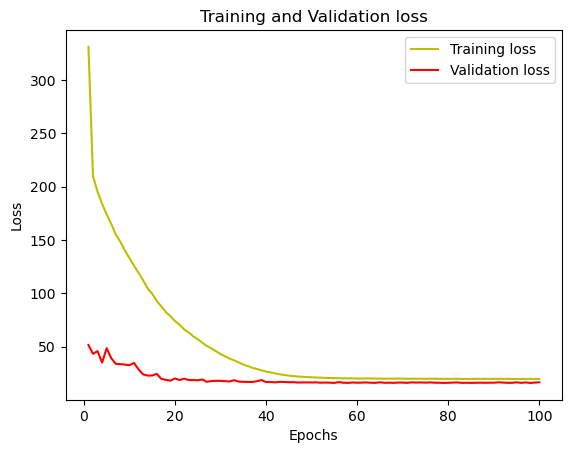

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
np.sqrt(history.history['val_loss'][-1])

4.054258467186077

In [66]:
predictions = model.predict(X_test[220:225])
print('predicted values are: ', predictions)
print('real values are: ', y_test[220:225])

1/1 [==============================] - 0s 51ms/step
predicted values are:  [[59.719975]
 [53.43756 ]
 [62.49724 ]
 [70.894325]
 [58.830986]]
real values are:  103488    60.15
62868     54.85
45701     68.10
43209     73.17
49366     58.11
Name: score, dtype: float64


In [41]:
predictions = model.predict(X_test[:11])
print('predicted values are: ', predictions)
print('real values are: ', y_test[:11])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [2]:
import pandas as pd
df = pd.read_csv('../data/wombi_employees.csv')

In [19]:
df_new = df[['most_recent_income','problem_solving_skill']].dropna()
df_new['most_recent_income']=df_new['most_recent_income'].replace(',','', regex=True).apply(pd.to_numeric)

In [20]:
df_new.head(10)

,most_recent_income,problem_solving_skill
1,54693,17.016506
3,44939,20.723280
4,57731,15.862225
5,60723,14.725214
6,71583,10.598648
7,59972,15.010481
8,63808,13.553051
9,43679,21.202096
10,62183,14.170282
11,55068,16.874109


In [24]:
total_avg = df_new.groupby('most_recent_income').mean()['problem_solving_skill']

In [61]:
total_avg

most_recent_income
14884     30.0
15018     30.0
16114     30.0
16884     30.0
17204     30.0
          ... 
100885     1.0
101162     1.0
101337     1.0
101360     1.0
102892     1.0
Name: problem_solving_skill, Length: 45573, dtype: float64

In [ ]:
df['feature1'].fillna(df['feature1'].mean(), inplace=True)

In [62]:
# for i in df['problem_solving_skill']:
#     if np.isnan(i) == False:
#         print('hello')
#     else:
#         print('true')

In [47]:
import numpy as np

In [40]:
df['most_recent_income']=df['most_recent_income'].replace(',','', regex=True).apply(pd.to_numeric)

In [66]:
df_new.

,most_recent_income,problem_solving_skill
1,54693,17.016506
3,44939,20.723280
4,57731,15.862225
5,60723,14.725214
6,71583,10.598648
...,...,...
233931,53862,17.332522
233932,52750,17.754821
233933,55147,16.844175
233934,68421,11.799902


In [67]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [ ]:
lin_reg.fit(X,y)